# Data Bootcamp: Zipf's Law
Jack (Quan Cheng) Xie<br>
Prof. Michael Waugh<br>
Data Bootcamp<br>
21 December 2017

## Project Overview

The *Zipf law* is a linguistic phenomenon where only a few percentage of words have most of the usage in any language. This is sometimes known as the lower law, the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle), or the 80/20 rule--a catchy name for a Pareto distribution where 80% of effects come from 20% of causes.

This Pareto principle does not only appears in linguistics, but in many places. Some famous (or infamouse) examples are income and wealth inequality (top 20% earners make 80% of income), software optimization (20% of bugs cause 80% of crashes), website traffic, etc. There are some cool youtube videos about this the phenomenon:   [The Zipf Mystery](https://www.youtube.com/watch?v=fCn8zs912OE) --- [Unfair](https://www.youtube.com/watch?v=xFmCZKq3o58).

The idea of the project is to observe this Zipf phenomenon in our daily life, specifically in the online space. We rank words by their frequencies from three different environments: Reddit, The New York Times, and Twitter. We can compare they vary through their word frequency density distributions.

As the Pareto principle follows some kind of negative exponential relationship, we can also compare the lingustic environments through parameters of exponential functions.

##  The Important Imports

In [1]:
import pandas as pd
import json
import requests, io
import csv

# For opening Zip and bz2 files
import zipfile as zf
import bz2
import shutil
import os

# For miscellaneous stuff
import time
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For Stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import display, clear_output

#import nltk as nltk

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Accessing the Data

In [2]:
def df_summary(dataframe):
    
    '''A function to summarize shape, columns,
    index, and return a DataFrame head-preview.'''
    
    print('Shape:', dataframe.shape, '\n')
    print('Columns:', list(dataframe.columns),'\n')
    print('Index:', dataframe.index)
    display(dataframe.head())

### Data I. Reddit Archives

Our first data source is from [Pushshift.io](https://pushshift.io/what-is-pushshift-io/). Pushshift is an open data initiative that ingests data from social media sites. We access the data from [this URL](https://files.pushshift.io/reddit/comments/). We are going to access their Reddit comments archives. The archives contains .bz2 files for each month between 2006 to 2017.

Some of the files are very big, so we will only use January data from a few years. Otherwise some of our data manipulations will take too long to run. We won't even use all of the data we do access, so for our purposes, just a few years provides a sufficient sample.

In [3]:
def get_reddit_file(file_name):
    
    '''Get and open Pushshift Reddit bz2 file'''
    
    url = 'https://files.pushshift.io/reddit/comments/'
    # Print the file our function is fetching so we can keep track
    print('Fetching:', file_name)
    resp = requests.get(url+file_name)
    # Print the request response
    print(file_name,resp)
    result = bz2.BZ2File(io.BytesIO(resp.content)) # Open the bz2 file
    clear_output() # Clear our print output after we have the file
    
    return result

In [4]:
# Combining bz2 files into one json
def get_reddit_archives(end_year):
    
    '''Gets Pushshift archive data between 2006 and end_year'''
    
    # Make list of year strings for our file names
    years = list(range(2006,end_year+1))
    for y in range(len(years)):
        years[y] = str(years[y])
    
    # Make list of file names with different years
    file_list = list()
    initial = 'RC_2006-01.bz2' # Access Data from 2006-01 to end_year-01
    for year in years:
        file_list.append(initial.replace('2006',year))
    
    # Read lines from the bz files directly to our output with JSON
    result = list()
    for file in file_list:
        bz_file = get_reddit_file(file)
        linelist = bz_file.readlines()
        for line in linelist:
            result.append(json.loads(line))
            
    return result

In [5]:
# Executing get function
t0 = time.time() # Time how long our pull function takes

all_archives = get_reddit_archives(2010) # Access data from 2006

t1 = time.time()
print('Time required: ', round(t1-t0),'seconds') # Print elpased time

Time required:  484 seconds


In [6]:
# Pandas DataFrame (This takes a minute too)
reddit = pd.DataFrame(all_archives)

In [7]:
# We're only take last 100,000 to make our lives a little easier
reddit = reddit.tail(100000)

df_summary(reddit)

    # We can upload the DataFrame to a csv to avoid repulling
    # the data every time we want to work from it.
#reddit.to_csv('reddit_sample.csv')


Shape: (100000, 23) 

Columns: ['archived', 'author', 'author_flair_css_class', 'author_flair_text', 'body', 'controversiality', 'created_utc', 'distinguished', 'downs', 'edited', 'gilded', 'id', 'link_id', 'name', 'parent_id', 'removal_reason', 'retrieved_on', 'score', 'score_hidden', 'stickied', 'subreddit', 'subreddit_id', 'ups'] 

Index: RangeIndex(start=4373742, stop=4473742, step=1)


,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,...,name,parent_id,removal_reason,retrieved_on,score,score_hidden,stickied,subreddit,subreddit_id,ups
4373742,True,[deleted],None,None,Pani Poni Dash,0,1264879115,None,0.0,False,...,t1_c0jowax,t3_aw498,NaN,1426199885,1,False,NaN,AskReddit,t5_2qh1i,1
4373743,True,Unlucky13,None,None,"I got called in last time it snowed this year,...",0,1264879117,None,0.0,True,...,t1_c0joway,t1_c0jovqq,NaN,1426199885,15,False,NaN,pics,t5_2qh0u,15
4373744,True,[deleted],None,None,For real. I don't go to church and I'm pretty ...,0,1264879117,None,0.0,False,...,t1_c0jowaz,t3_aw3e2,NaN,1426199885,1,False,NaN,politics,t5_2cneq,1
4373745,True,showmesomescars,None,None,"can't go wrong with ""am i wrong"".",0,1264879118,None,0.0,False,...,t1_c0jowb0,t1_c0jotli,NaN,1426199885,1,False,NaN,Music,t5_2qh1u,1
4373746,True,[deleted],None,None,probably,0,1264879118,None,0.0,False,...,t1_c0jowb1,t3_aw49u,NaN,1426199885,1,False,NaN,PS3,t5_2qhhw,1


### Data II. New York Times Article API

The second text source we use is a [New York Times article search API](https://developer.nytimes.com/article_search_v2.json#/Documentation). We can't get full articles from the API, but we can get "snippets."

Since the API has an access frequency limit, we can only get a small sample from the data. We will crawl the data verrry slowly so our API key doesn't get timed out.

*UPDATE*: The crawl functions doesn't seem to work anymore, so we will turn to the csv saved from before, posted on [my github](https://github.com/qcx201/work_in_progress/blob/master/nyt.csv).

In [8]:
# List of years for crawl (str) from 2006 to 2017
years = list(range(2006,2017+1))
for y in range(len(years)):
    years[y] = str(years[y])
    
# List of months for crawl (str)
months = list()
for m in range(1,12+1):
    if m < 10:
        months.append('0'+str(m))
    else:
        months.append(str(m))

# We won't end up using days to iterate, but it may come in handy
def days(month):
    
    '''Returns list of days in a given month'''
    
    m30 = ['04','06','09','11'] # 30-day months
    res = list()
    for d in range(1,10):
        res.append('0'+str(d))   
    if month == '02': # Feb 28-days
        for d in range(10,28+1):
            res.append(str(d))
    elif month in m30: # 30-day months
        for d in range(10,30+1):
            res.append(str(d))
    else: # 31-day months
        for d in range(10,31+1):
            res.append(str(d))
    return res

In [9]:
# Retreiving data 'documents' from API call
def get_articles(year, month, day):
    
    '''Get data for articles from API.'''
    
    url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

    nyt_key = '7b36694d6ed447e4a3da0b2bf411d0f8'
        # backup API keys if one gets timed out
    #nyt_key = 'e3fba4ee4f0944619aa6e7be1fc73eab'
    #nyt_key = '770978643efb463e84871368163388d7'
    
    parameters = {'api-key' : nyt_key,
              'begin_date' : year+month+day,
              'sort' : 'oldest'}

    resp = requests.get(url, params = parameters)
    data = resp.json()

    articles = data(year, month, day)['response']['docs']
    
    return articles

In [10]:
def get_nyt():
    
    '''Scrape API with iteration'''
    
    result = list()
    for year in years:
        print('Start:', year)
        
        for month in months: # We can get 10 articles for each month
            for day in ['01','15']: # Two start dates in the month
                
                try: # try to get article with our function above
                    docs = get_articles(year, month, day)
                except: # Sleep to wait it out if timed out
                    print(year, month, day, 'Sleep')
                    # Tells us it's sleeping
                    time.sleep(10)
                    docs = get_articles(year, month, day)
                    
                for article in docs:
                    result.append(article)
                print(year, month, day) # Status check
                time.sleep(2) # Sleep to wait
        print(year, 'OK') # Tell us a year is done
    clear_output() # Clear status print updates
    return result

In [11]:
# Executing... Wish me luck!
t0 = time.time()

nyt_api = get_nyt()

t1 = time.time()
print('Time required: ', round(t1-t0),'seconds')

Start: 2006
2006 01 01 Sleep


TypeError: 'dict' object is not callable

In [ ]:
# Pandas DataFrame and summarize
nyt = pd.DataFrame(nyt_api)
df_summary(nyt) # We should get around 2880 instances
#nyt.to_csv('nyt.csv') # Upload

### New York Times: Backup Plan
Looks like there are some problems with crawling the nyt API. We will use the backup csv from when this crawl did work.

In [12]:
url = 'https://raw.githubusercontent.com/qcx201/work_in_progress/master/nyt.csv'
nyt = pd.read_csv(url)
df_summary(nyt) # We should get around 2880 instances
#nyt.to_csv('nyt.csv') # Upload

Shape: (2870, 21) 

Columns: ['Unnamed: 0', '_id', 'abstract', 'blog', 'byline', 'document_type', 'headline', 'keywords', 'multimedia', 'new_desk', 'print_page', 'pub_date', 'score', 'section_name', 'slideshow_credits', 'snippet', 'source', 'type_of_material', 'uri', 'web_url', 'word_count'] 

Index: RangeIndex(start=0, stop=2870, step=1)


,Unnamed: 0,_id,abstract,blog,byline,document_type,headline,keywords,multimedia,new_desk,...,pub_date,score,section_name,slideshow_credits,snippet,source,type_of_material,uri,web_url,word_count
0,0,4fd24e778eb7c8105d7f036c,NaN,{},"{'original': 'By ALISON BERKLEY', 'person': [{...",article,"{'main': 'Long, Steep and Lovely in Aspen', 'k...","[{'name': 'glocations', 'value': 'ASPEN (COLO)...",[],Travel Desk,...,2006-01-01T00:00:00Z,1.0,NaN,NaN,While jet setters schuss down the groomed slop...,The New York Times,News,NaN,https://www.nytimes.com/2006/01/01/travel/01su...,568
1,1,4fd24e778eb7c8105d7f0372,George Ernsberger letter on Jesse Green's arti...,{},NaN,article,"{'main': 'The Making of an Ice Princess', 'kic...","[{'name': 'persons', 'value': 'HUGHES, EMILY',...",[],Magazine,...,2006-01-01T00:00:00Z,1.0,NaN,NaN,Thanks for Jesse Green's terrific article (Dec...,The New York Times,Letter,NaN,https://query.nytimes.com/gst/fullpage.html?re...,41
2,2,4fd24e778eb7c8105d7f037b,NaN,{},"{'original': 'By KELLY FEENEY', 'person': [{'f...",article,"{'main': 'Quick Bite/Millburn; When in Essex, ...",[],[],New Jersey Weekly Desk,...,2006-01-01T00:00:00Z,1.0,NaN,NaN,The word famiglia in a food store's name can b...,The New York Times,Review,NaN,https://query.nytimes.com/gst/fullpage.html?re...,350
3,3,4fd24e778eb7c8105d7f0381,British and Dutch researchers conduct study on...,{},"{'original': 'By ALEX WILLIAMS', 'person': [{'...",article,{'main': 'Hangover Helpers: Beyond Sheep Eyes'...,"[{'name': 'glocations', 'value': 'GREAT BRITAI...","[{'rank': 0, 'subtype': 'thumbnail', 'caption'...",Style Desk,...,2006-01-01T00:00:00Z,1.0,NaN,NaN,"As people wake up from another New Year's Eve,...",The New York Times,News,NaN,https://www.nytimes.com/2006/01/01/fashion/sun...,1346
4,4,4fd24e778eb7c8105d7f038a,NaN,{},"{'original': 'By HOWARD MARKEL', 'person': [{'...",article,"{'main': ""If the Avian Flu Hasn't Hit, Here's ...",[],[],Week in Review Desk,...,2006-01-01T00:00:00Z,1.0,NaN,NaN,WILD birds have completed their seasonal migra...,The New York Times,News,NaN,https://query.nytimes.com/gst/fullpage.html?re...,329


### Data III. Twitter Collection

We get Twitter data from another dataset host: [Followthehashtag](http://www.followthehashtag.com/datasets/free-twitter-dataset-usa-200000-free-usa-tweets/).

The data contains 200,000 US tweets collected over 48 hours in April of 2016. The dataset comes from excel files in a zip.

In [13]:
# Accessing the zip file
url = 'http://followthehashtag.com/content/uploads/USA-Geolocated-tweets-free-dataset-Followthehashtag.zip'

t0 = time.time()
resp = requests.get(url) # Get file
tw_zip = zf.ZipFile(io.BytesIO(resp.content)) # Open Zip
t1 = time.time() # Thank god... it doesn't take forever
print('Time required: ', round(t1-t0),'seconds')

Time required:  118 seconds


In [14]:
twfilenames = tw_zip.namelist() # Get list of files in zip
for i in range(len(twfilenames)):
    print('File',str(i)+': ',twfilenames[i])
# The file we want is number 7 in the list

File 0:  heatmap_x_usa_x_filter_nativeretweets.xlsx
File 1:  __MACOSX/
File 2:  __MACOSX/._heatmap_x_usa_x_filter_nativeretweets.xlsx
File 3:  coverage_x_usa_x_filter_nativeretweets.xlsx
File 4:  __MACOSX/._coverage_x_usa_x_filter_nativeretweets.xlsx
File 5:  geolocation_x_usa_x_filter_nativeretweets.xlsx
File 6:  __MACOSX/._geolocation_x_usa_x_filter_nativeretweets.xlsx
File 7:  dashboard_x_usa_x_filter_nativeretweets.xlsx
File 8:  __MACOSX/._dashboard_x_usa_x_filter_nativeretweets.xlsx


In [15]:
# Read to DataFrame with Pandas... easy!
twitter = pd.read_excel(tw_zip.open(tw_zip.namelist()[7]),
                        sheet_name = 'Stream')

In [16]:
# Get rid of spaces in column names
twitter_cols = list(twitter.columns)
new_twitter_cols = [twitter_cols[i].
                    replace(' ','_') for i in range(len(twitter_cols))]
twitter.columns = new_twitter_cols

In [17]:
# Summarize DataFrame
df_summary(twitter)

#twitter.to_csv('twitter.csv')

Shape: (204820, 19) 

Columns: ['Tweet_Id', 'Date', 'Hour', 'User_Name', 'Nickname', 'Bio', 'Tweet_content', 'Favs', 'RTs', 'Latitude', 'Longitude', 'Country', 'Place_(as_appears_on_Bio)', 'Profile_picture', 'Followers', 'Following', 'Listed', 'Tweet_language_(ISO_639-1)', 'Tweet_Url'] 

Index: RangeIndex(start=0, stop=204820, step=1)


,Tweet_Id,Date,Hour,User_Name,Nickname,Bio,Tweet_content,Favs,RTs,Latitude,Longitude,Country,Place_(as_appears_on_Bio),Profile_picture,Followers,Following,Listed,Tweet_language_(ISO_639-1),Tweet_Url
0,721318437075685382,2016-04-16,12:44,Bill Schulhoff,BillSchulhoff,"Husband,Dad,GrandDad,Ordained Minister, Umpire...","Wind 3.2 mph NNE. Barometer 30.20 in, Rising s...",NaN,NaN,40.760278,-72.954722,US,"East Patchogue, NY",http://pbs.twimg.com/profile_images/3788000007...,386.0,705.0,24.0,en,http://www.twitter.com/BillSchulhoff/status/72...
1,721318436173979648,2016-04-16,12:44,Daniele Polis,danipolis,"Viagens, geek, moda, batons laranja, cabelos c...",Pausa pro café antes de embarcar no próximo vô...,NaN,NaN,32.898349,-97.039196,US,"Grapevine, TX",http://pbs.twimg.com/profile_images/7041760340...,812.0,647.0,16.0,pt,http://www.twitter.com/danipolis/status/721318...
2,721318434169102336,2016-04-16,12:44,Kasey Jacobs,KJacobs27,Norwich University Class of 2017,Good. Morning. #morning #Saturday #diner #VT #...,NaN,NaN,44.199476,-72.504173,US,"Barre, VT",http://pbs.twimg.com/profile_images/7169585649...,179.0,206.0,2.0,en,http://www.twitter.com/KJacobs27/status/721318...
3,721318429844582400,2016-04-16,12:44,Stan Curtis,stncurtis,"transcendental music, art for art's sake, craf...",@gratefuldead recordstoredayus 🌹🌹🌹 @ TOMS MUSI...,NaN,NaN,39.901474,-76.606817,US,"Red Lion, PA",http://pbs.twimg.com/profile_images/6962528246...,1229.0,2071.0,11.0,en,http://www.twitter.com/stncurtis/status/721318...
4,721318429081407488,2016-04-16,12:44,Dave Borzymowski,wi_borzo,When in doubt....Panic.,Egg in a muffin!!! (@ Rocket Baby Bakery - @ro...,NaN,NaN,43.060849,-87.998309,US,"Wauwatosa, WI",http://pbs.twimg.com/profile_images/6595279129...,129.0,833.0,9.0,en,http://www.twitter.com/wi_borzo/status/7213184...


## Data Cleaning

We can now clean the data. We remove all the columns other than the text and date columns. Then we get rid of undesirable columns with NaN values. Then we clean the texts for any symbols that might throw our word frequency distribution off.

### Cleaning Reddit

In [18]:
    # Our saved csv
#reddit = pd.read_csv('reddit_sample.csv')

reddit = reddit[['created_utc','body']]
#reddit.set_index('created_utc', inplace = True)
reddit.head()
reddit = reddit.dropna()

In [19]:
# Drop "[deleted]" and "[removed]" text bodies
deleted = list()

for i in range(len(reddit)):
    if reddit.body.iloc[i] == '[deleted]' or reddit.body.iloc[i] == '[removed]':
        deleted.append(reddit.index[i])
reddit = reddit.drop(deleted)

In [20]:
# Cleaning UTC date

    # Clean str UTCs and non-UTC values in UTC column
non_int = list()
for i in range(len(reddit)):
    if type(reddit.created_utc.iloc[i]) == str:
        # All our UTCs should have at least 10 digits
        if len(reddit.created_utc.iloc[i])<10:
            # Index the 'bad' UTCs
            non_int.append(reddit.index[i])            
reddit = reddit.drop(non_int) # Drop the bad UTCs

reddit['created_utc'] = reddit.created_utc.astype(int)

# Convert utc to datetime
test = reddit.head()

    # Make list of date from utc to datetime
dates = list() 
for utc in reddit.created_utc:
    dates.append(dt.datetime.fromtimestamp(utc))
    
    # Add dates list to dataframe
reddit['dates'] = dates
    # Delete UTC column
reddit.drop(['created_utc'],axis=1,inplace=True)

display(reddit.tail())

,body,dates
4473736,.. is that.. why yes it is! k-lite codec pack!...,2010-01-31 18:59:53
4473737,Why not include the flight costs too?,2010-01-31 18:59:54
4473738,"How, is that humanly, possible.\n\n,",2010-01-31 18:59:55
4473739,I wouldn't be surprised if the XBLA/PSN/Wii Vi...,2010-01-31 18:59:56
4473740,Pidgeon.,2010-01-31 18:59:56


### Text Cleaning Function
We will use this function to clean our other datasets too.

In [21]:
def clean_text(df,text_col_name):
    
    '''Cleans text column in dataframe'''

    # Make all upper case
    df[text_col_name] = df[text_col_name].str.upper()

    # Remove numbers and symbols
    symbols = '`-=~!@#$%^&*()_+[]\{}|;:,./<>?"1234567890'

    for s in symbols:
        df[text_col_name] = df[text_col_name].str.replace(s,'')
    
    # Split strings in their columns
    df[text_col_name] = df[text_col_name].str.split()
    return df

In [22]:
# Execute clean text function
reddit = clean_text(reddit,'body')
display(reddit.head())

    # Rename the variable so we can access this database later
feed_reddit = reddit

,body,dates
4373742,"[PANI, PONI, DASH]",2010-01-30 14:18:35
4373743,"[I, GOT, CALLED, IN, LAST, TIME, IT, SNOWED, T...",2010-01-30 14:18:37
4373744,"[FOR, REAL, I, DON'T, GO, TO, CHURCH, AND, I'M...",2010-01-30 14:18:37
4373745,"[CAN'T, GO, WRONG, WITH, AM, I, WRONG]",2010-01-30 14:18:38
4373746,[PROBABLY],2010-01-30 14:18:38


### Cleaning New York Times

In [23]:
# The same drill

#nyt = pd.read_csv('nyt.csv')

nyt = nyt[['pub_date','snippet']]
nyt = nyt.dropna()

# Drop duplicates from articles that were crawled twice in the same month
nyt = nyt.drop_duplicates()

nyt = clean_text(nyt,'snippet')
display(nyt.head())

feed_nyt = nyt

,pub_date,snippet
0,2006-01-01T00:00:00Z,"[WHILE, JET, SETTERS, SCHUSS, DOWN, THE, GROOM..."
1,2006-01-01T00:00:00Z,"[THANKS, FOR, JESSE, GREEN'S, TERRIFIC, ARTICL..."
2,2006-01-01T00:00:00Z,"[THE, WORD, FAMIGLIA, IN, A, FOOD, STORE'S, NA..."
3,2006-01-01T00:00:00Z,"[AS, PEOPLE, WAKE, UP, FROM, ANOTHER, NEW, YEA..."
4,2006-01-01T00:00:00Z,"[WILD, BIRDS, HAVE, COMPLETED, THEIR, SEASONAL..."


### Cleaning Twitter

In [24]:
# Once more unto the trenches, dear friends

#twitter = pd.read_csv('twitter.csv')

twitter = twitter[['Date','Tweet_content']]
twitter = clean_text(twitter,'Tweet_content')

display(twitter.head())

feed_twitter = twitter

,Date,Tweet_content
0,2016-04-16,"[WIND, MPH, NNE, BAROMETER, IN, RISING, SLOWLY..."
1,2016-04-16,"[PAUSA, PRO, CAFÉ, ANTES, DE, EMBARCAR, NO, PR..."
2,2016-04-16,"[GOOD, MORNING, MORNING, SATURDAY, DINER, VT, ..."
3,2016-04-16,"[GRATEFULDEAD, RECORDSTOREDAYUS, 🌹🌹🌹, TOMS, MU..."
4,2016-04-16,"[EGG, IN, A, MUFFIN, ROCKET, BABY, BAKERY, ROC..."


## Word Frequency Distribution
Now we can manipulate the word lists in the DataFrames columns to make new DataFrames we can manipulate for our graphs.

In [25]:
def word_freq(name, feed_df):
    
    '''Returns database of words and their frequency. Input name
    of DataFrames (for our merge later) and the feed DataFrames'''
    
    # Creating the word frequency distribution
    
        # Create list of all words in the dataframe
    words = list()
    for i in range(len(feed_df)):
        words.extend(feed_df.iloc[i])
        
        # Create list of unique words    
    word_set = list(set(words))

        # Create list of unique words and their frequency
    word_freq = list()
    for i in word_set:
        word_freq.append([i,words.count(i)])
    
    
    # Creating 
    word = name+'_word'
    freq = name+'_freq'
    labels = [word,freq]
    
    df = pd.DataFrame.from_records(word_freq, columns=labels)
    df = df.sort_values([freq,word],ascending = [0,1])
    df = df.reset_index().drop('index',axis=1)
    
    return df

In [26]:
def word_perc(name, df, numwords):

    '''Outputs word frequency in percentages. Input numwords
    for number of words to make our population.'''

    y_var = name+'_perc'
    
    # Determine length of the 
    if type(numwords) == str:
        if numwords.lower() == 'all':
            df = df
    elif type(numwords) == int or type(numwords) == float:
        df = df.head(int(numwords))
    else:
        print('List length error')

    freq = name+'_freq'
    #df[xvar] = (df.index+1)
    df[y_var] = (df[freq])/(df[freq].agg('sum'))*100

    df
    
    return df

In [27]:
def perc_cum(df):

    """Returns cumulative frequency percentage.
    Requires word_perc() first."""
    
    for col in df.columns:
        if 'perc' in col:
            name = col

    cum_list = list()
    perc = 0

    for i in range(len(df)):
        perc += df[name].iloc[i]
        cum_list.append(perc)
    df[name+'_cum'] = cum_list

    return df

## Word Frequency Dataframes
Now we use the functions above to create our DataFrames.

In [28]:
# We use .head() to limit the Dataframe size...
# Otherwise proceesing the data would take too long

t0 = time.time()

# Feed into frequency function
reddit_all = word_freq('reddit',feed_reddit.body.head(10000))
nyt_all = word_freq('nyt',feed_nyt.snippet)
twitter_all = word_freq('twitter',feed_twitter.Tweet_content.head(10000))

t1 = time.time()
print('Time required: ', round(t1-t0),'seconds')

Time required:  209 seconds


In [29]:
# Number of words we want to rank. We're going to do the top 100 words for now.
# Either an integer or 'all'. I wouldn't recommend 'all'
num_ranked_words = 100

### Reddit

In [30]:
# Get freq percentage and cumulative percentage
reddit = word_perc('reddit',reddit_all,num_ranked_words)
reddit = perc_cum(reddit)

clear_output() # Clear warning output from function

display(reddit.head())
display(reddit.tail())

,reddit_word,reddit_freq,reddit_perc,reddit_perc_cum
0,THE,15396,8.460363,8.460363
1,TO,9825,5.399004,13.859368
2,A,9007,4.949499,18.808867
3,AND,7776,4.273044,23.081911
4,I,7744,4.255459,27.337370


,reddit_word,reddit_freq,reddit_perc,reddit_perc_cum
95,THOSE,479,0.263219,98.963611
96,RIGHT,477,0.262120,99.225731
97,INTO,470,0.258273,99.484004
98,SHOULD,470,0.258273,99.742277
99,BEING,469,0.257723,100.000000


### New York Times

In [31]:
# Same same
nyt = word_perc('nyt',nyt_all,num_ranked_words)
nyt = perc_cum(nyt)

clear_output() # Clear warning output from function

display(nyt.head())
display(nyt.tail())

,nyt_word,nyt_freq,nyt_perc,nyt_perc_cum
0,THE,1774,13.994951,13.994951
1,OF,1039,8.196592,22.191543
2,A,945,7.455033,29.646576
3,AND,880,6.942253,36.588829
4,TO,642,5.064689,41.653518


,nyt_word,nyt_freq,nyt_perc,nyt_perc_cum
95,TIMES,28,0.220890,99.147996
96,CHICKEN,27,0.213001,99.360997
97,LOVE,27,0.213001,99.573998
98,MOTHER,27,0.213001,99.786999
99,TIME,27,0.213001,100.000000


### Twitter

In [32]:
# Same same
twitter = word_perc('twitter',twitter_all,num_ranked_words)
twitter = perc_cum(twitter)

clear_output() # Clear warning output from functions

display(twitter.head())
display(twitter.tail())

,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum
0,IN,2501,6.168759,6.168759
1,JOB,1871,4.614853,10.783612
2,THE,1721,4.244876,15.028488
3,TO,1681,4.146215,19.174703
4,AT,1664,4.104284,23.278988


,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum
95,ONE,138,0.340379,98.673014
96,CITY,137,0.337913,99.010927
97,CARE,135,0.332980,99.343906
98,CALIFORNIA,133,0.328047,99.671953
99,JOIN,133,0.328047,100.000000


### Word Rank (Combining all platforms)

In [40]:
# We merge the three dataframes into one dataframe called wordrank
    # Merge reddit and nyt
wordrank = pd.merge(reddit,nyt,how='outer',right_index=True,left_index=True)
    # Merge wordrank with twitter
wordrank = pd.merge(wordrank,twitter,how='outer',right_index=True,left_index=True)
    # Add work rank column for our regression later
wordrank['rank'] = (wordrank.index+1)

display(wordrank.head(15))
display(wordrank.tail(15))

,reddit_word,reddit_freq,reddit_perc,reddit_perc_cum,nyt_word,nyt_freq,nyt_perc,nyt_perc_cum,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum,rank
0,THE,15396,8.460363,8.460363,THE,1774,13.994951,13.994951,IN,2501,6.168759,6.168759,1
1,TO,9825,5.399004,13.859368,OF,1039,8.196592,22.191543,JOB,1871,4.614853,10.783612,2
2,A,9007,4.949499,18.808867,A,945,7.455033,29.646576,THE,1721,4.244876,15.028488,3
3,AND,7776,4.273044,23.081911,AND,880,6.942253,36.588829,TO,1681,4.146215,19.174703,4
4,I,7744,4.255459,27.337370,TO,642,5.064689,41.653518,AT,1664,4.104284,23.278988,5
5,OF,7388,4.059831,31.397202,IN,611,4.820133,46.473651,A,1649,4.067287,27.346274,6
6,YOU,5485,3.014101,34.411302,BY,342,2.698012,49.171663,HIRING,1573,3.879831,31.226106,7
7,THAT,5460,3.000363,37.411665,ON,310,2.445566,51.617229,FOR,1087,2.681104,33.907210,8
8,IS,5334,2.931124,40.342789,FOR,308,2.429789,54.047018,THIS,975,2.404854,36.312064,9
9,IT,5144,2.826715,43.169504,IS,286,2.256232,56.303250,AND,913,2.251930,38.563994,10


,reddit_word,reddit_freq,reddit_perc,reddit_perc_cum,nyt_word,nyt_freq,nyt_perc,nyt_perc_cum,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum,rank
85,VERY,537,0.295091,96.170416,MY,30,0.236668,96.907542,NURSE,151,0.372444,95.103964,86
86,ALSO,532,0.292343,96.462759,BEEN,29,0.228779,97.136321,ST,151,0.372444,95.476408,87
87,WHY,528,0.290145,96.752904,LIST,29,0.228779,97.365099,NJ,150,0.369978,95.846385,88
88,WELL,525,0.288496,97.041401,MAKE,29,0.228779,97.593878,HAVE,148,0.365045,96.211430,89
89,YOU'RE,524,0.287947,97.329348,YOUR,29,0.228779,97.822657,WAS,147,0.362578,96.574008,90
90,GO,515,0.283001,97.612349,FOOD,28,0.220890,98.043547,IF,146,0.360111,96.934119,91
91,THAT'S,511,0.280803,97.893152,FORMER,28,0.220890,98.264437,RN,145,0.357645,97.291764,92
92,BEEN,496,0.272560,98.165712,JUST,28,0.220890,98.485327,NOW,142,0.350245,97.642010,93
93,COULD,491,0.269813,98.435525,LIFE,28,0.220890,98.706216,ALL,141,0.347779,97.989789,94
94,TOO,482,0.264867,98.700392,SHE,28,0.220890,98.927106,YOUR,139,0.342846,98.332634,95


### Looking at the table
Something interesting from glancing at the table is type of words that show up in the top ranks. In Reddit and NYT, it's sort of what one would expect, words like "the", "to", "a"--determiner, prepositions, conjunctions--the connective tissues of grammar. Even the rank of those words are strikingly similar.

However, with Twitter that's not the case. We see some more non-grammar words pop up on the top. Maybe, because of Twitter's character limit, people tend to omit those grammar words more for economoy of language. Maybe that'll translate to lesser "inequality" in the word frequency (maybe Twitter is the great democratizer we've all been waiting for?).

# The 80/20 Rule

Let's plot the word frequency distribution based on the 80/20 cutoff. With the function below, we can compare the total frequency percentage of the top 20% used words, and the % rank at the 80% cumulative use.

We also include the log-rank to log-frequency regression statistics, which we will go further into when we plot data against our Zipf functions.

In [34]:
def plot_8020(show,show_regression,show_pred):
    
    '''Plot frequency density bar graph showing top 20% words used'''
    
        # Plot three figures stacked ontop each other
    fig, ax = plt.subplots(3, figsize = (10,10))

    top20 = round(.2*len(wordrank)) - 1 # position of 20th ranked word (-1 for indexing)

        # Plot title
    plt.suptitle('Top 20% Rank Cumulative Frequency', size = 16, fontweight = 'bold')
    
        #list of source names to iterate with
    source_list = ['reddit','nyt','twitter']

    for i in range(len(source_list)):
        
        ######################### Print Regression results ############################
        results = smf.ols("np.log({yvar}_perc) ~ np.log(rank)"
                          .format(yvar = source_list[i]), data=wordrank).fit()
        coeff = results.params['np.log(rank)']
        intercept = results.params['Intercept']
        
        if show_regression == True:

            # Print Regression Statistics
            m1 = 'Log Rank Coeff: '+str(round(coeff,4))
            m2 = 'Intercept: '+str(round(intercept,3))
            m3 = 'R-Squared: '+str(round(results.rsquared,3))

            statistics = '\n'.join([m1,m2,m3])

            ax[i].text(75,6,'Regression Statistics:',
                    horizontalalignment='left',verticalalignment='bottom',
                    size=12,fontweight='bold',fontstyle='italic')

            ax[i].text(75,6,statistics,
                    horizontalalignment='left', verticalalignment='top',
                    size=12)
        ############################################################################
        
            # Plot the frequency density distribution
        ax[i].bar(wordrank['rank'], wordrank[source_list[i]+'_perc'],
                  align='edge', width=1,alpha=.5)
        
            # Plot prediction line
        if show_pred == True:
            
            ax[i].plot(wordrank['rank'],np.exp(intercept)*wordrank['rank']**coeff,
                      label = 'Prediction',alpha = .6, linewidth = 4,
                       linestyle = '-.',color = 'tab:purple')

            # Index for 80% cumulative frequency
        cumfreq80 = wordrank.index[wordrank[source_list[i]+'_perc_cum'] > 80][0] 
        
        # Show top 20% words
        if show == 20:
        
            ax[i].bar(wordrank['rank'].head(top20),
                      wordrank[source_list[i]+'_perc'].head(top20),
                      align='edge', width=1,alpha=1)

            ax[i].set_xlim(1,len(wordrank))
            ax[i].set_ylim(0,15)

            ax[i].set_title('\n'+source_list[i].title(),size = 14)
            
            # Construct message
            cum_freq_str = str(round(wordrank[source_list[i]+'_perc_cum'].loc[top20],2))

            message1 = "Top 20% Used Words:"
            message2 =  cum_freq_str + '% Total Use'
            
            # Print line and message
            ax[i].axvline(x=top20+1, label= "20% Most Used", linestyle='--', linewidth=2)
            ax[i].text(top20+3, 10, message1, horizontalalignment='left',
                       verticalalignment='bottom',size=14)
            ax[i].text(top20+3, 10, message2, horizontalalignment='left',fontweight='bold',
                       verticalalignment='top',size=14) 
            # 80% Line
            ax[i].axvline(x=cumfreq80+1, label= "80% Usage", linestyle=':',
                          linewidth=2, color ='r', alpha=.5)

        # Show 80% Cumulative distribution
        elif show == 80:
            
            ax[i].bar(wordrank['rank'], wordrank[source_list[i]+'_perc'], color = 'tab:blue',
                      align='edge', width=1, alpha=.5)
        
            ax[i].bar(wordrank['rank'].head(cumfreq80),
                      wordrank[source_list[i]+'_perc'].head(cumfreq80), color = 'tab:orange',
                      align='edge', width=1, alpha=1)

            ax[i].set_xlim(1,len(wordrank))
            ax[i].set_ylim(0,15)

            ax[i].set_title('\n'+source_list[i].title(),size = 14)
                        
            # Construct message
            rank_str = str(cumfreq80/len(wordrank)*100)

            cumfreq_str= str(round(wordrank[source_list[i]+'_perc_cum'][cumfreq80],2))
            message1 = cumfreq_str + "% Total Use:"
            message2 = "Top " + rank_str +'% Used Words\nRank '+str(cumfreq80)

            # Print line and message
            ax[i].axvline(x=cumfreq80+1, label= "80% Usage",
                          linestyle='--', linewidth=2, color ='r', alpha=1)
            ax[i].text(cumfreq80+3, 10, message1,
                       horizontalalignment='left',verticalalignment='bottom', size = 14)
            ax[i].text(cumfreq80+3, 10, message2,
                       horizontalalignment='left',verticalalignment='top',
                       fontweight='bold', size = 14)        
            # 20% Line
            ax[i].axvline(x=top20+1, label= "20% Most Used",
                          linestyle=':', linewidth=2,alpha = .5)
        
        ############################################################################
        
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["top"].set_visible(False)
        
        ax[i].legend()
        

    
    # Some leftover formatting stuff
    ax[1].set_title("New York Times",size = 14)
    ax[2].set_xlabel("Word Frequency Rank", size=16,fontweight='bold')
    ax[1].set_ylabel('Word Frequency % in population\n', size = 16,fontweight='bold')

    plt.show()

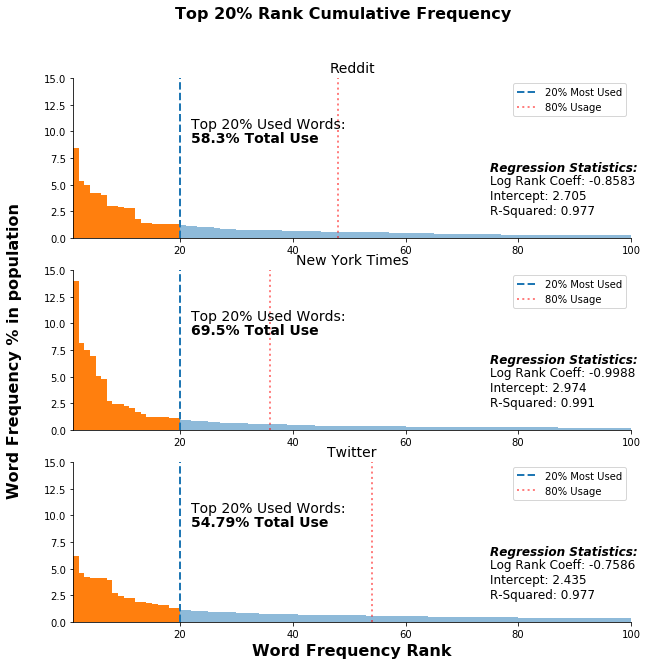

In [35]:
# Plot 20
plot_8020(20, True, False)

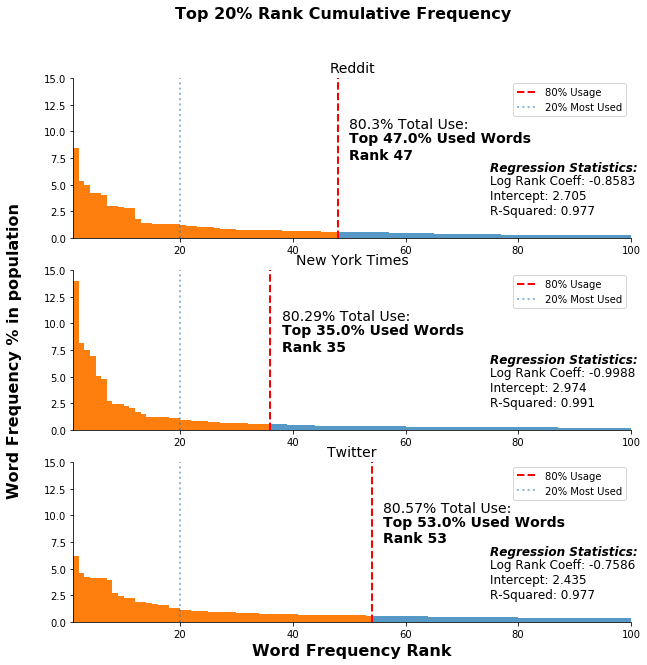

In [36]:
# Plot 80
plot_8020(80, True, False)

### 80/20? Not really.
We definitely see an curving density distribution, but the exact porportions are not as prononuced as 80/20. Though we've only used the top 100 words, the biggest effect-cause ratio we get is about 70-20, in the NYT.

What's interesting is the difference of the ratios between the platforms. It seems that our suspicions about the formality of language may be correct. The more grammatically rigorous the text source, the higher the frequency inequality.

This higher inequality also correlates to a larger negative Log Rank Coefficient. It seems that the larger the coefficient, the more dramatic the curve.

## Zipf!
Now we plot the Zipf with log-frequency and log-word rank to look at the distribution exponent parameter.

We plot the actual data against the regression prediction to see how closely our regression parameter holds.

In [37]:
def plot_zipf(source, source_name, 
              diff_shape, # If the data and prediction (bool)
              show_fit_line, # Show fit line in scatter plot (bool)
              print_summary): # Print stats summary

    '''Plots Zipf relationship on the log-freq log-rank scale'''
    
    # Rename source for source_perc column index
    source = source + "_perc"
    
    # Regression results
    results = smf.ols("np.log({yvar}) ~ np.log(rank)".format(yvar = source), 
                      data=wordrank).fit()
    # Plotting
    fig, ax = plt.subplots(figsize = (10,6))

    ax.set_title(source_name+': Data v Prediction', size=18,fontweight='bold')

        # Plot data/ The plot sizes are porportional to percentage use
        # and inversely porportional to rank
    data = ax.scatter(np.log(wordrank["rank"]), np.log(wordrank[source]),
               alpha = .5, s = wordrank[source]*300/wordrank["rank"],
               label = source_name)
    
        # Plot Prediction
    pred = results.predict(exog = wordrank["rank"])

        # From input shape. If data and prediction are the same shape,
        # it is easier to compare their sizes
    if diff_shape == True:
        shape = 0
    elif diff_shape == False:
        shape = 3
    
    prediction = ax.scatter(np.log(wordrank["rank"]), pred,
               marker = (6, shape, 0), s = np.exp(pred)*300/wordrank["rank"],
               alpha = .5, #color = 'orange',
               label = 'Prediction')
    
        # Plot fit line (if True)
    if show_fit_line == True:
            # Data line
        ax.plot(np.log(wordrank["rank"]), np.log(wordrank[source]),
                alpha = .5, linewidth = 2, linestyle=':')
            # Prediction fit line
        ax.plot(np.log(wordrank["rank"]), pred, linewidth = 2, #color = 'orange',
                alpha = .5,linestyle='-')

        # Formatting
    ax.set_ylabel('Log Frequency %',size=14,fontweight='bold')
    ax.set_xlabel('Log Rank',size=14,fontweight='bold')

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    
    ################ Print Regression Statistics ################
    message1 = 'Log Rank Coeff: '+str(round(results.params['np.log(rank)'],4))
    message2 = 'Intercept: '+str(round(results.params['Intercept'],3))
    message3 = 'R-Squared: '+str(round(results.rsquared,3))

    statistics = '\n'.join([message1,message2,message3])

    ax.text(np.log(1),0,'Regression Statistics:',
            horizontalalignment='left',verticalalignment='bottom',
            size=12,fontweight='bold',fontstyle='italic')

    ax.text(np.log(1),0,statistics,
            horizontalalignment='left', verticalalignment='top',
            size=12)
    ################################################################
    
    # Legend
    legend_prop = dict(size=10,weight='bold',style='italic')
            # Plot the two legends separately
    first_legend = plt.legend(handles=[data], bbox_to_anchor=(.7, .92),
                              prop=legend_prop, loc='upper left')
            # Add fisrt legend
    ax = plt.gca().add_artist(first_legend)
            # Add second legend
    plt.legend(handles=[prediction], bbox_to_anchor=(.7, .75),
               prop=legend_prop,loc='upper left')

    
    plt.show()

    # Print regression summary if True
    if print_summary == True:
        print(results.summary())

## Plot the Zipf!

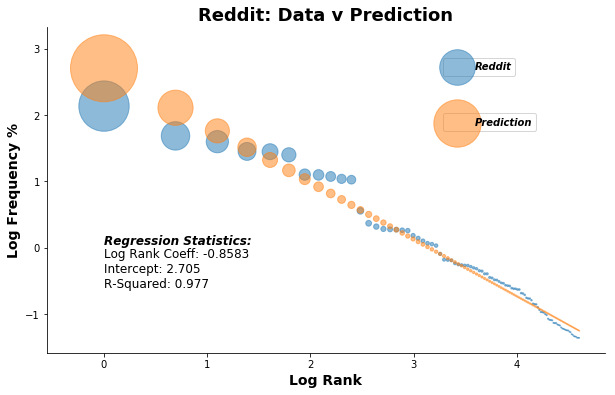

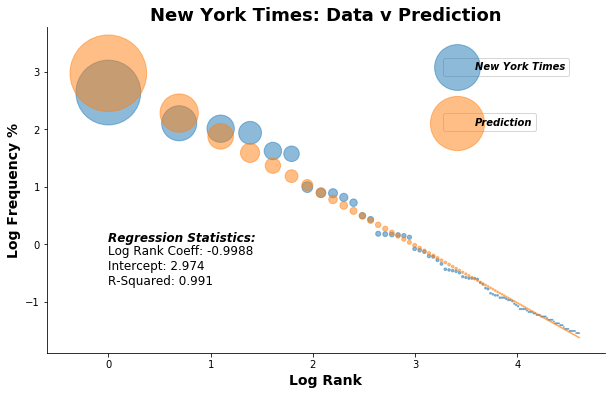

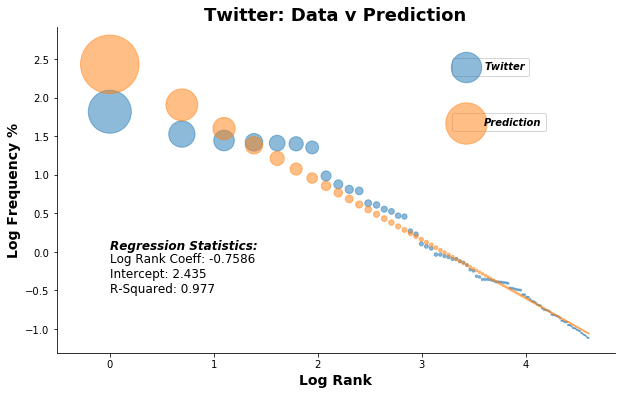

In [38]:
# Plot through iteration
source_list = ['reddit','nyt','twitter']
name_list = ['Reddit','New York Times','Twitter']

# We plot with every False to first get a clean look
for i in range(len(source_list)):
    plot_zipf(source_list[i],name_list[i],False,False,False)

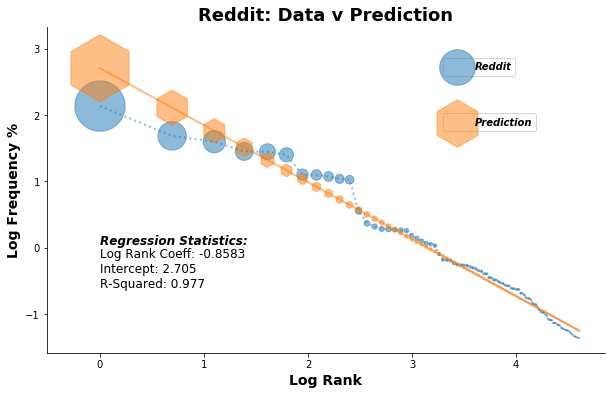

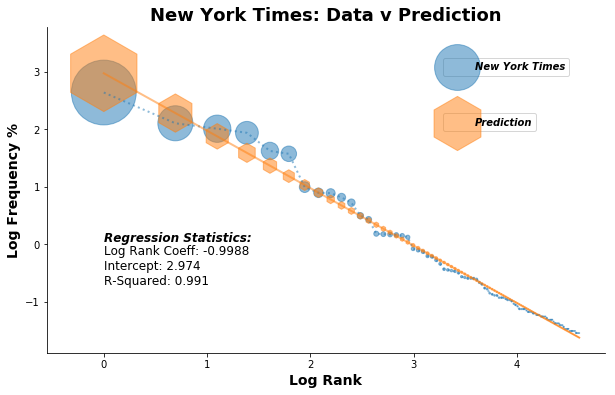

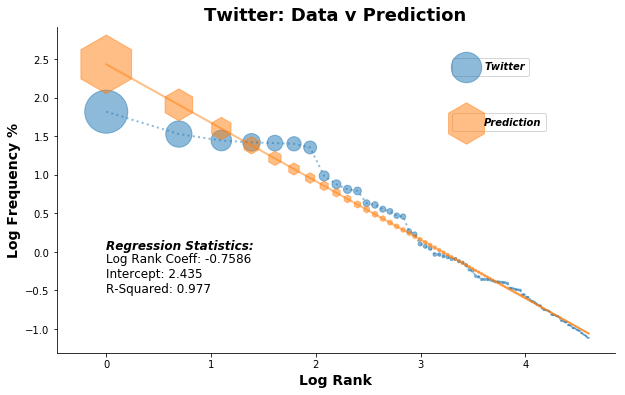

In [39]:
# Plot through iteration
source_list = ['reddit','nyt','twitter']
name_list = ['Reddit','New York Times','Twitter']

# We plot with fit line and different shapes to better
# distinguish between if in grayscale
for i in range(len(source_list)):
    plot_zipf(source_list[i],name_list[i],True,True,False)

## Zipf Conclusion

So it seems that the graphs hold pretty well. The R-squared on our log-log regression is very high on all three, implying a highly statistically significant exopnential relationship between the rank and the frequency of these words. Even if it's not 80-20, there is some kind of truth to that relationship.

Once again, we see that the fit is just a little better for the New York Times. The relationship between the grammar of the forum and the distribution is with this a little inconclusive, but that may be an interesting next step.